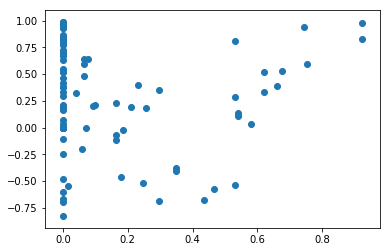

(0.3401911189922243, 0.03663481923548028)
SpearmanrResult(correlation=0.2536398710591995, pvalue=0.12440080865701854)


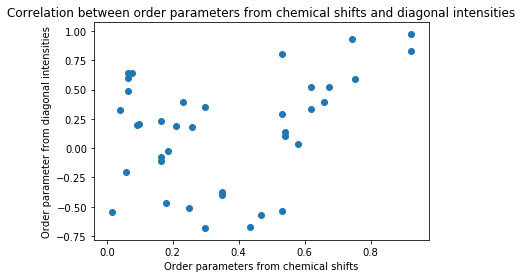

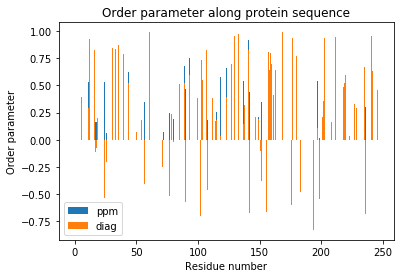

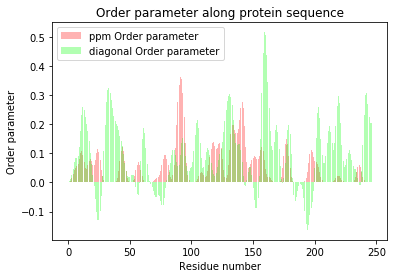

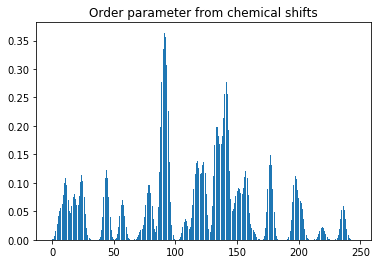

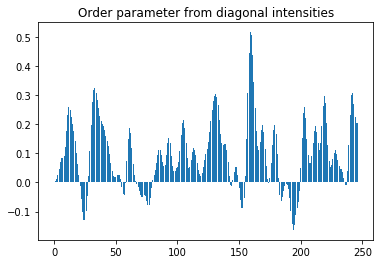

<__main__.order_parameter_plotter instance at 0x000000000BFB8388>

In [48]:
import numpy
import os,re
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class order_parameter_plotter():
    def __init__(self):
        self.peak_file_parser()
        self.relaxation_parameter()
        ppm_order_par=self.wobble_masker()
        diag_order_par=self.diag_file_parser()
        max_index=max(max(ppm_order_par),max(diag_order_par))
        x=numpy.arange(max_index)
        y_ppm,y_diag=numpy.zeros(max_index),numpy.zeros(max_index)
        for i in x:
            try:
                y_ppm[i]=ppm_order_par[i]
            except:
                pass
            try:
                y_diag[i]=diag_order_par[i]
            except:
                pass
        mask=numpy.logical_and(y_ppm!=0., y_diag!=0.)
        plt.scatter(y_ppm,y_diag)
        plt.show()
        plt.scatter(y_ppm[mask],y_diag[mask])
        print pearsonr(y_ppm[mask],y_diag[mask])
        print spearmanr(y_ppm[mask],y_diag[mask])
        plt.xlabel('Order parameters from chemical shifts')
        plt.ylabel('Order parameter from diagonal intensities')
        plt.title('Correlation between order parameters from chemical shifts and diagonal intensities')
        plt.savefig('correlation_plot.png')
        plt.show()
        
        plt.bar(x,y_ppm,label='ppm')
        plt.bar(x,y_diag,label='diag')
        plt.legend()
        plt.xlabel('Residue number')
        plt.ylabel('Order parameter')
        plt.title('Order parameter along protein sequence')
        plt.savefig('order_parameter_histogram.png')
        plt.show()
        
        y_ppm=gaussian_filter(y_ppm,sigma=2.)
        y_diag=gaussian_filter(y_diag,sigma=2.)
        plt.bar(x,y_ppm,fc=(1.,0.,0.,0.3),label='ppm Order parameter')
        plt.bar(x,y_diag,fc=(0.,1.,0.,0.3),label='diagonal Order parameter')
        plt.legend()
        plt.xlabel('Residue number')
        plt.ylabel('Order parameter')
        plt.title('Order parameter along protein sequence')
        plt.savefig('order_parameter_histogram_blurred.png')
        plt.show()
        plt.bar(x,y_ppm)
        plt.title("Order parameter from chemical shifts")
        plt.show()
        plt.bar(x,y_diag)
        plt.title("Order parameter from diagonal intensities")
        plt.show()
    
    def residue_parser(self,residue_str):
        res_letter=residue_str[0]
        integers=[int(s) for s in re.findall(r'-?\d+\.?\d*', residue_str)]
        out_str=''
        if(res_letter=='I'):
            out_str='ILE'+' '+str(integers[0])+' A'
        elif(res_letter=='A'):
            out_str='ALA'+' '+str(integers[0])+' A'
        elif(res_letter=='L'):
            if('D1' in residue_str):
                out_str='LEU'+' '+str(integers[0])+' A'
            elif('D2' in residue_str):
                out_str='LEU'+' '+str(integers[0])+' B'
        elif(res_letter=='V'):
            if('G1' in residue_str):
                out_str='VAL'+' '+str(integers[0])+' A'
            elif('G2' in residue_str):
                out_str='VAL'+' '+str(integers[0])+' B'
        if(out_str==''):
            print 'BLANK AMINO ACID CODE. AMINO ACID STRING TO BE PARSED = ',residue_str
            sys.exit(100)
        return out_str
    
    def peak_file_parser(self,peak_file_dir='correlate',peak_list_dir='ein_noes'):
        peak_list=self.peak_list_parser(peak_list_dir)
        file=open(peak_file_dir, 'r')
        cross,reflected={},{}
        diag_1,diag_2={},{}
        c1_shift,c2_shift={},{}
        h1_shift,h2_shift={},{}
        for line in file:
            data=line.split()
            res1=self.residue_parser(data[0])
            res2=self.residue_parser(data[1])
            c1,h1=data[2],data[3]
            c2,h2=data[4],data[5]
            v1,v2=data[6],data[7]
            a1,a2=data[14],data[15]
            if not(res1 in cross):
                cross[res1]={}
                reflected[res1]={}
                diag_1[res1]={}
                diag_2[res1]={}
                c1_shift[res1],c2_shift[res1]={},{}
                h1_shift[res1],h2_shift[res1]={},{}
            cross[res1][res2]=v1
            reflected[res1][res2]=v2
            diag_1[res1][res2]=a1
            diag_2[res1][res2]=a2
            c1_shift[res1][res2],c2_shift[res1][res2]=c1,c2
            h1_shift[res1][res2],h2_shift[res1][res2]=h1,h2
        file.close()
        self.map_key,self.map_index={},{}
        i=0
        for res1 in cross:
            self.map_key[res1]=i
            self.map_index[i]=res1
            i+=1

        num=len(cross)
        self.cross,self.reflected,self.d1,self.d2=numpy.zeros((num,num)),numpy.zeros((num,num)),numpy.zeros((num,num)),numpy.zeros((num,num))
        self.c1,self.h1,self.c2,self.h2=numpy.zeros((num,num)),numpy.zeros((num,num)),numpy.zeros((num,num)),numpy.zeros((num,num))
        mask_matrix=numpy.zeros((num,num),dtype=bool)

        peak_list_return=[]
        for peak in peak_list:
            res1,res2=peak
            try:
                i1,i2=self.map_key[res1],self.map_key[res2]
                self.cross[i1,i2]=cross[res1][res2]
                self.cross[i2,i1]=reflected[res1][res2]
                self.reflected[i1,i2]=reflected[res1][res2]
                self.d1[i1,i2]=diag_1[res1][res2]
                self.d2[i1,i2]=diag_2[res1][res2]
                self.c1[i1,i2],self.c2[i1,i2]=c1_shift[res1][res2],c2_shift[res1][res2]
                self.h1[i1,i2],self.h2[i1,i2]=h1_shift[res1][res2],h2_shift[res1][res2]
            except KeyError:
                pass
        

    def peak_list_parser(self,peak_list_dir):
        file=open(peak_list_dir,'r')
        peak_list=[]
        for line in file:
            res1,res2=line.split()[0],line.split()[1]
            res1,res2=self.peak_list_str_parser(res1),self.peak_list_str_parser(res2)
            peak_list.append((res1,res2))
            peak_list.append((res1,res1))
            peak_list.append((res2,res2))
            if(res1[0:3]=='LEU' or res1[0:3]=='VAL'):
                peak_list.append((res1[0:-1]+'B',res2))
                peak_list.append((res1[0:-1]+'B',res1[0:-1]+'B'))
            if(res2[0:3]=='LEU' or res2[0:3]=='VAL'):
                peak_list.append((res1,res2[0:-1]+'B'))
                peak_list.append((res2[0:-1]+'B',res2[0:-1]+'B'))
        return peak_list
    
    def peak_list_str_parser(self,res_str):    
        res_letter=res_str[0]
        integers=[int(s) for s in re.findall(r'-?\d+\.?\d*', res_str)]
        if(res_letter=='I'):
            name='ILE'+' '+str(integers[0])+' A'
        elif(res_letter=='A'):
            name='ALA'+' '+str(integers[0])+' A'
        elif(res_letter=='L'):
            name='LEU'+' '+str(integers[0])+' A'
        elif(res_letter=='V'):
            name='VAL'+' '+str(integers[0])+' A'
        return name
    
    def wobble_masker(self,lim=0.85):
        order_dict={}
        for i in numpy.arange(self.cross.shape[0]):
            res=self.map_index[i]
            res_num=int(res.split()[1])
            if(res[0:3]=='ILE'):
                p_g=(14.8-self.c1[i,i])/5.5
                if(p_g<1. and p_g>0.):
                    order_dict[res_num]=4.*(p_g-0.5)**2
            elif(res[0:3]=='LEU'):
                res_a,res_b=res[0:-1]+'A',res[0:-1]+'B'
                i_a,i_b=self.map_key[res_a],self.map_key[res_b]
                c_a,c_b=self.c2[i_a,i_a],self.c2[i_b,i_b]
                p_t=0.5+(c_a-c_b)/10.
                if(p_t<1. and p_t>0.):
                    order_dict[res_num]=4.*(p_t-0.5)**2
        return order_dict

    
    def diag_file_parser(self,diag_file_dir='diag_nmr_sim'):
        file=open(diag_file_dir, 'r')
        order_dict={}
        for line in file:
            (typ,num,ab,nmr,xrd)=line.split()
            nmr,xrd=float(nmr),float(xrd)
            num=int(num)
            if(nmr!=0. and xrd!=0.):
                if(num in order_dict):
                    hyp=numpy.sqrt(nmr**2 + xrd**2)
#                     order_par=(nmr-xrd)/nmr
                    order_par=(nmr-xrd)/hyp
                    order_dict[num]=(order_dict[num]+order_par)/2.
                else:
                    hyp=numpy.sqrt(nmr**2 + xrd**2)
#                     order_par=(nmr-xrd)/nmr
                    order_par=(nmr-xrd)/hyp
                    order_dict[num]=order_par
        file.close()
        return order_dict
    
    def color_calc(self,frac):
        r,g,b=0.,0.,0.
        r=frac
        b=1.-frac
        return r,g,b

    
    def relaxation_parameter(self,diag_file_dir='diag_nmr_sim'):
        file=open(diag_file_dir, 'r')
        order_dict={}
        for line in file:
            (typ,num,ab,nmr,xrd)=line.split()
            nmr,xrd=float(nmr),float(xrd)
            num=int(num)
            if(nmr!=0. and xrd!=0.):
                if(num in order_dict):
                    hyp=numpy.sqrt(nmr**2 + xrd**2)
                    order_par=1./0.4 * numpy.log(xrd/nmr)
                    order_dict[num]=(order_dict[num]+order_par)/2.
                else:
                    hyp=numpy.sqrt(nmr**2 + xrd**2)
                    order_par=1./0.4 * numpy.log(xrd/nmr)
                    order_dict[num]=order_par
        file.close()
        max_index=max(order_dict)
        max_value=max(order_dict.values())
        min_value=min(order_dict.values())
        write=open('relaxation_output','w')
        for i in numpy.arange(max_index):
            r,g,b=0.2,0.2,0.2
            try:
                frac=(order_dict[i]-min_value)/(max_value-min_value)
                r,g,b=self.color_calc(frac)
            except:
                pass
            write.write('set_color color%i = [%.2f,%.2f,%.2f]\n'%(i,r,g,b))
            write.write('color color%i, resi %i\n'%(i,i))
        write.close()
    
    
order_parameter_plotter()     